In [1]:
import os
import sys
from datetime import datetime
from tqdm import tqdm # progress bar
import h5py # for loading .h5 file
import matplotlib.pyplot as plt

sys.path.append('../../../src')

## some parameters

In [2]:
outDir='./results'
batchSize=128
imageSize=64
nc = 3
nz = 100 # size of the latent z vector
ngf = 64 # relates to the depth of feature maps carried through the generator
ndf = 64 # sets the depth of feature maps propagated through the discriminator
epochs=60
lr=2e-4
beta1=0.5 # beta1 for adam. default=0.5
d_labelSmooth=0.1 # for D, use soft label "1-labelSmooth" for real samples. 0.25 from imporved-GAN paper

try:
    os.makedirs(outDir)
except OSError:
    pass

## only use dataset and dataloader from pytorch
tensors loaded using `pytorch` will be converted to `tortto` tensors later.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.utils import save_image
from torch import tensor as torch_tensor

In [4]:
class AnimeDataset(Dataset):
    def __init__(self, fn, transform):
        super().__init__()
        self.fn=fn
        self.dataset = None
        self.transform=transform
        with h5py.File(fn, "r") as file:
            self.dataset_len=len(file['images'])

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.fn, 'r')["images"]
        if self.transform is not None:
            return self.transform(self.dataset[idx])
        return self.dataset[idx]
dataset=AnimeDataset('dataset/anime_faces.h5', transform=Compose([
    ToTensor(),
    Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
]))

dataloader = DataLoader(dataset, batch_size=batchSize, drop_last=True, shuffle=True, num_workers=4)
print(f'contains {len(dataset)} images of size {tuple(dataset[0].shape)}')

contains 99869 images of size (3, 64, 64)


Check dataloading speed to make sure there is no IO bottleneck. **Will take some time to speed up**.

If there is a `h5py objects cannot be pickled` error, delete `num_workers=4` from Dataloader.

In [5]:
for _ in tqdm(dataloader):
    _=1

100%|██████████| 780/780 [00:09<00:00, 85.97it/s]


## the rest is done in pytortto

In [6]:
import tortto as tt
import tortto.nn as nn
import tortto.nn.functional as F
import tortto.optim as optim

## define a network

In [7]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.transConv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.transConv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.transConv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.transConv4 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        # one extra layer
        self.extra1 = nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf)
        # final layer
        self.final = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.transConv1(x)), 0.2, True)  # B,z,1,1->B,ngf*8,4,4
        x = F.leaky_relu(self.bn2(self.transConv2(x)), 0.2, True)  # B,ngf*8,4,4->B,ngf*4,8,8
        x = F.leaky_relu(self.bn3(self.transConv3(x)), 0.2, True)  # B,ngf*4,8,8->B,ngf*2,16,16
        x = F.leaky_relu(self.bn4(self.transConv4(x)), 0.2, True)  # B,ngf*2,16,16->B,ngf,32,32
        x = F.leaky_relu(self.bn5(self.extra1(x)), 0.2, True)  # B,ngf,32,32->B,ngf,32,32
        x = tt.tanh(self.final(x))  # B,ngf,32,32->B,nc,64,64
        return x


class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super().__init__()
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)  # B,nc,64,64->B,ndf,32,32
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)  # B,ndf,32,32->B,ndf*2,16,16
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)  # B,ndf*2,16,16->B,ndf*4,8,8
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)  # B,ndf*4,8,8->B,ndf*8,4,4
        x = self.conv5(x)
        return x.view(-1)  # B,1,1,1->B,

In [8]:
G=Generator(nz, ngf, nc).cuda()
D=Discriminator(ndf, nc).cuda()

G.apply(weights_init)
D.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()

optimizerD = optim.Adam(D.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr = lr, betas = (beta1, 0.999))

## start training
This cell is empty because Jupyter notebook can't run in google cloud while hang up. Codes are copied to a .py file and use `nohup` command to train.

In [ ]:
# if os.path.exists('logs/log.txt'):
#     raise OSError('log.txt already exists')

# noise = tt.randn(batchSize, nz, 1, 1).cuda()
# fixed_noise = tt.randn(64, nz, 1, 1).cuda()
# label = tt.zeros(batchSize).cuda()
# real_label = 1
# fake_label = 0

# for epoch in range(epochs):
#     loop = tqdm(dataloader)
#     for i, real in enumerate(loop, 0):
        
#         real = tt.tensor(real.numpy()).cuda()
        
#         # (1) Update D network
#         optimizerD.zero_grad()

#         # train with real
#         output = D(real)
#         nn.init.constant_(label, 1 - d_labelSmooth)
#         lossD_real = criterion(output, label)
#         lossD_real.backward()

#         # train with fake
#         nn.init.normal_(noise)
#         fake = G(noise)
#         output = D(fake.detach())
#         nn.init.zeros_(label)
#         lossD_fake = criterion(output, label)
#         lossD_fake.backward()
        
#         optimizerD.step()

#         # Update G network
#         optimizerG.zero_grad()
#         output = D(fake)
#         nn.init.ones_(label) # fake labels are real for generator cost
#         lossG = criterion(output, label)
#         lossG.backward()
#         optimizerG.step()

#     with tt.no_grad():
#         fake = G(fixed_noise)
#         save_image(torch_tensor(fake.data*0.5+0.5), f'{outDir}/fake_samples_epoch_{str(epoch).zfill(3)}.png', nrow=8)
    
#     checkpoint = {
#         'generator': G.state_dict(),
#         'discriminator': D.state_dict()
#             }
#     tt.save(checkpoint, f'models/checkpoint_{str(epoch).zfill(3)}.npy')
#     with open('logs/log.txt','a') as f:
#         f.write('epoch{} finished at {}\n'.format(str(epoch).zfill(3), datetime.now().strftime("%m/%d/%Y, %H:%M:%S")))

## Plots

In [10]:
def transition(to_plot, num):
    fig,axs=plt.subplots(len(to_plot),num,figsize=(2*len(to_plot)*1.1,len(to_plot)*1.1))
    i=0
    for start,stop in to_plot:
        step=(stop-start)/(num-1)
        z=tt.randn(num, nz, 1, 1)
        for n in range(num):
            z[n,:,:,:] = start + n*step
        with tt.no_grad():
            y = tt.moveaxis(G(z)*0.5+0.5, 1, -1).numpy()
        for j in range(num):
            axs[i,j].imshow(y[j])
            axs[i,j].axis('off')
        i+=1
    fig.tight_layout()
    plt.show()

In [11]:
# need to set to eval mode, otherwise it's not independent on batch dimension due to batch norm.
# for example, if you create a person with gray hair using a single noise vector,
# that person will probably have yellow hair, if you put that single noise vector into a batch of noise vectors.
G.eval()
G=G.cpu()
checkpoint = tt.load('models/checkpoint_099.npy')
G.load_state_dict(checkpoint['generator'])

<All keys matched successfully>

### plot 64 random generated images

In [12]:
# # AI enlarge: https://bigjpg.com/
# tt.manual_seed(42)
# size=8
# noise = tt.randn(size*size, nz, 1, 1)
# # nn.init.normal_(noise,0,0.8)
# with tt.no_grad():
#     fake = G(noise)
#     image = tt.moveaxis(fake*0.5+0.5, 1, -1).numpy()
# fig,axs=plt.subplots(size,size,figsize=(size+1,size+1))
# for i in range(size):
#     for j in range(size):
#         axs[i,j].imshow(image[size*i+j])
#         axs[i,j].axis('off')
# fig.tight_layout()
# plt.show()

### plot transient of selected images
results will differ on different machines. Need to manually select images that look good by running the above cell. Don't forget to try different random seeds. 

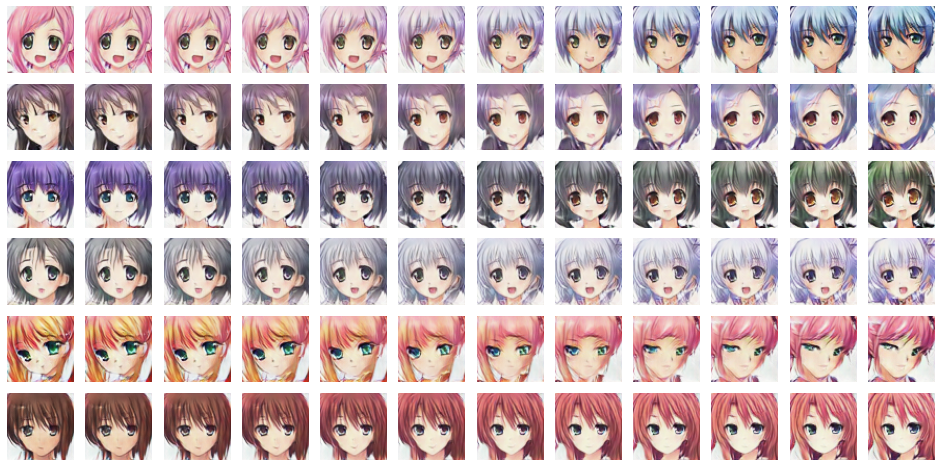

In [13]:
to_plot=[]

#
tt.manual_seed(42)
noise = tt.randn(64, nz, 1, 1)
to_plot.extend([(noise[-22], noise[-37]),(noise[34], noise[38]),(noise[-12], noise[35])])

#
nn.init.normal_(noise,0,0.8)
to_plot.extend([(noise[-8], noise[-22])])

#
tt.manual_seed(10)
noise = tt.randn(64, nz, 1, 1)
to_plot.extend([(noise[12], noise[16]),(noise[-12], noise[-33])])

# plot all selected images
transition(to_plot, 12)